In [1]:
import matplotlib.pyplot as plt
import xarray as xr
from metpy.units import units
import metpy.calc as mpcalc
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import sklearn.cluster as cluster
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids 

plt.style.use('fivethirtyeight')

In [2]:
# random seed for reproducibility
np.random.seed(0)

In [3]:
'''
Define Model Parameters
'''
MODEL_DATE = '20240811'
MODEL_CYCLE = '06z'

# Define area of interest
LAT = 32.90
LON = -97.0

FORECAST_DATES = [(datetime.today() + timedelta(days=day)).strftime('%Y-%m-%d') 
                  for day in range(1, 16)]

In [4]:
base_url = f'https://nomads.ncep.noaa.gov/dods/gefs/gefs{MODEL_DATE}/gefs_pgrb2ap5_all_{MODEL_CYCLE}'

ds = xr.open_dataset(base_url, decode_times=True)

/Users/rhawthorne/miniconda3/envs/metpy_env/lib/python3.12/site-packages/xarray/coding/times.py:172: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [5]:
t_max = ds.tmax2m.metpy.sel(lat=LAT, lon=360+LON, method='nearest') * units('K')

In [6]:
t_max = t_max.metpy.convert_units('degF')
t_max

Magnitude,[[nan 83.85720825195312 92.09761810302734 ... 96.26302337646484 100.71907806396484 98.50203704833984] [nan 83.92999267578125 85.74081420898438 ... 100.05309295654297 103.14370727539062 100.5669174194336] [nan 83.95394134521484 96.33987426757812 ... 97.42999267578125 104.34687805175781 102.68843841552734] ... [nan 84.32962036132812 91.03913879394531 ... 96.83140563964844 104.11012268066406 98.56065368652344] [nan 82.96072387695312 93.88245391845703 ... 99.740966796875 102.6158676147461 99.60435485839844] [nan 83.75003814697266 90.68153381347656 ... 96.42452239990234 99.59809112548828 98.16184997558594]]
Units,degree_Fahrenheit


In [7]:
df = t_max.to_dataframe('temp')
df.dropna(inplace=True)
df.reset_index(inplace=True)
df

,ens,time,lat,lon,temp
0,1.0,2024-08-11 12:00:00,33.0,263.0,83.857208
1,1.0,2024-08-11 18:00:00,33.0,263.0,92.097618
2,1.0,2024-08-12 00:00:00,33.0,263.0,98.636017
3,1.0,2024-08-12 06:00:00,33.0,263.0,96.425514
4,1.0,2024-08-12 12:00:00,33.0,263.0,88.425377
...,...,...,...,...,...
1979,31.0,2024-08-26 06:00:00,33.0,263.0,98.580811
1980,31.0,2024-08-26 12:00:00,33.0,263.0,91.560326
1981,31.0,2024-08-26 18:00:00,33.0,263.0,96.424522
1982,31.0,2024-08-27 00:00:00,33.0,263.0,99.598091


In [8]:
# Only include rows with 00 UTC
# High temps usually occur in the 6 hours prior over the Americas
df = df[df['time'].dt.strftime('%H:%M:%S').str.contains('00:00:00')]

In [9]:
df.reset_index(drop=True, inplace=True)
df

,ens,time,lat,lon,temp
0,1.0,2024-08-12,33.0,263.0,98.636017
1,1.0,2024-08-13,33.0,263.0,103.014618
2,1.0,2024-08-14,33.0,263.0,102.901787
3,1.0,2024-08-15,33.0,263.0,103.331573
4,1.0,2024-08-16,33.0,263.0,104.444054
...,...,...,...,...,...
491,31.0,2024-08-23,33.0,263.0,108.115463
492,31.0,2024-08-24,33.0,263.0,103.414520
493,31.0,2024-08-25,33.0,263.0,104.803963
494,31.0,2024-08-26,33.0,263.0,100.712601


In [26]:
df_time = df.groupby(['time'])
last_forecast_timestep = df_time.get_group((FORECAST_DATES[-1],))[['temp']]

In [11]:
def calculate_elbow_cluster_number(data, min_clusters, max_clusters, metric='euclidean'):
    """
    Calculates the ideal number of clusters from k-medoids using the elbow method with a Pandas DataFrame as input.
    Creates a graph to visualize the within-cluster sum of squares (WCSS).
    
    Arguments:
    data -- The input data points as a Pandas DataFrame.
    max_clusters -- The maximum number of clusters to consider.
    metric -- The distance metric to be used (default: 'euclidean').
    
    Returns:
    The ideal number of clusters determined by the elbow method.
    """
    wcss = []  # Within-cluster sum of squares
    
    for n_clusters in range(min_clusters, max_clusters + 1):
        # Convert the DataFrame to a NumPy array
        data_array = data.values
        
        # Perform k-medoids clustering
        kmedoids = KMedoids(n_clusters=n_clusters, metric=metric)
        kmedoids.fit(data_array)
        
        # Compute the within-cluster sum of squares (WCSS)
        wcss.append(kmedoids.inertia_)
    
    # Calculate the differences in WCSS
    diff_wcss = np.diff(wcss)
    
    # Find the ideal number of clusters based on the elbow point
    ideal_clusters = np.argmax(diff_wcss) + min_clusters  # Add min_clusters due to range start
    print(ideal_clusters)
    
    # Create a graph to visualize the within-cluster sum of squares (WCSS)
    plt.plot(range(min_clusters, max_clusters + 1), wcss, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.title('WCSS for K-Medoids Clustering')
    plt.show()
    
    return ideal_clusters

[39.693443, 25.984367, 20.437256, 19.29863]
4


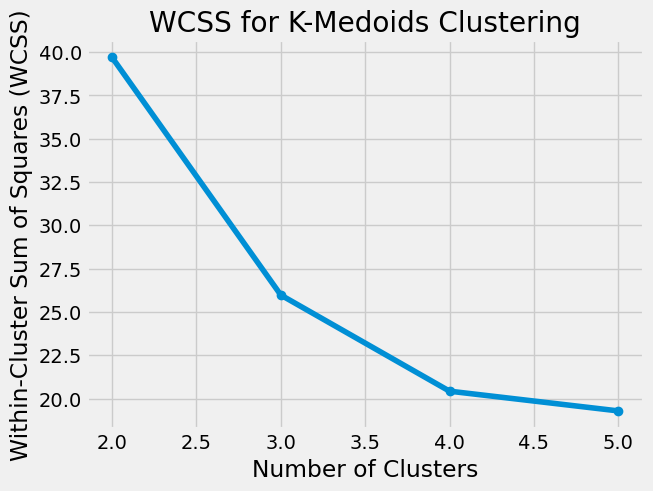

In [12]:
elbow_scr = calculate_elbow_cluster_number(last_forecast_timestep, 2, 5)

In [13]:
def calculate_cluster_number(data, min_clusters, max_clusters, metric='euclidean'):
    """
    Calculates a preferred number of clusters from k-medoids using the silhouette score with a Pandas DataFrame as input.
    Creates a graph to visualize the silhouette scores.
    
    Arguments:
    data -- The input data points as a Pandas DataFrame.
    max_clusters -- The maximum number of clusters to consider.
    metric -- The distance metric to be used (default: 'euclidean').
    
    Returns:
    The preferred number of clusters determined by the silhouette score.
    """
    silhouette_scores = []
    
    for n_clusters in range(min_clusters, max_clusters + 1):
        # Convert the DataFrame to a NumPy array
        data_array = data.values
        
        # Perform k-medoids clustering
        kmedoids = KMedoids(n_clusters=n_clusters, metric=metric)
        labels = kmedoids.fit_predict(data_array)
        
        # Compute the silhouette score
        silhouette_avg = silhouette_score(data_array, labels, metric=metric)
        silhouette_scores.append(silhouette_avg)
    
    # Find the preferred number of clusters based on the maximum silhouette score
    preferred_clusters = np.argmax(silhouette_scores) + min_clusters  # Add min_clusters due to range start
    
    # Create a graph to visualize the silhouette scores
    plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for K-Medoids Clustering')
    plt.show()
    
    return preferred_clusters

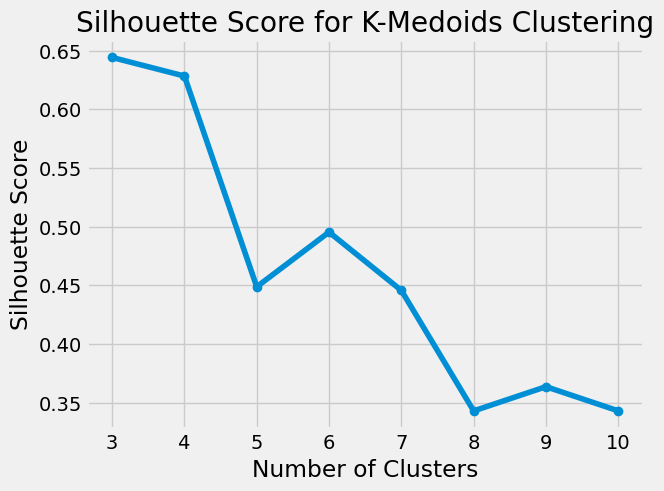

3

In [14]:
silhouette_scr = calculate_cluster_number(last_forecast_timestep, 3, 10)
silhouette_scr

In [15]:
# Either elbow_scr or silhouette_scr
number_clusters = silhouette_scr

In [16]:
cluster_centers_dict = {}

for date in FORECAST_DATES:
    single_forecast_date = df_time.get_group((date,))
    p25 = single_forecast_date['temp'].quantile(.25)
    p50 = single_forecast_date['temp'].median()
    p75 = single_forecast_date['temp'].quantile(.75)
    kmedo = KMedoids(n_clusters=number_clusters, random_state=1)
    kmedo.fit(single_forecast_date[['temp']])
    cluster_centers = kmedo.cluster_centers_.flatten()
    cluster_centers = np.append(cluster_centers, [p25, p50, p75])
    
    # Add the cluster centers to the dictionary with the date as the key
    cluster_centers_dict[date] = cluster_centers

# Create a DataFrame from the dictionary
df_cluster_centers = pd.DataFrame.from_dict(cluster_centers_dict, orient='index')
df_cluster_centers = df_cluster_centers.rename_axis('date').reset_index()

# Rename last few columns to add p25, p50, p75
col_names = list(df_cluster_centers.columns)
p25_column = int(col_names[-3])
p50_column = int(col_names[-2])
p75_column = int(col_names[-1])
df_cluster_centers.rename(columns={p25_column: 'p25', p50_column: 'p50', p75_column: 'p75'}, 
                          inplace=True)

df_cluster_centers

,date,0,1,2,p25,p50,p75
0,2024-08-12,99.121834,95.702118,101.699776,97.553425,99.121834,100.619545
1,2024-08-13,103.092239,105.242973,99.638634,100.312340,103.070045,104.367203
2,2024-08-14,102.369888,104.298645,97.846764,99.919441,102.901787,104.140087
3,2024-08-15,101.210007,103.866333,104.957275,102.078941,103.746086,104.383297
4,2024-08-16,103.910004,106.429993,101.091515,102.234589,103.910004,105.425350
5,2024-08-17,104.658173,107.582626,101.888412,102.565193,104.494591,106.705173
6,2024-08-18,106.984146,111.912117,103.740318,104.180874,106.620552,107.599983
7,2024-08-19,103.549980,106.499207,109.670029,103.918137,106.225594,107.691719
8,2024-08-20,105.662987,101.050591,108.624565,103.972435,106.070030,108.300388
9,2024-08-21,106.257896,102.478653,109.129997,103.221302,106.257896,108.618225


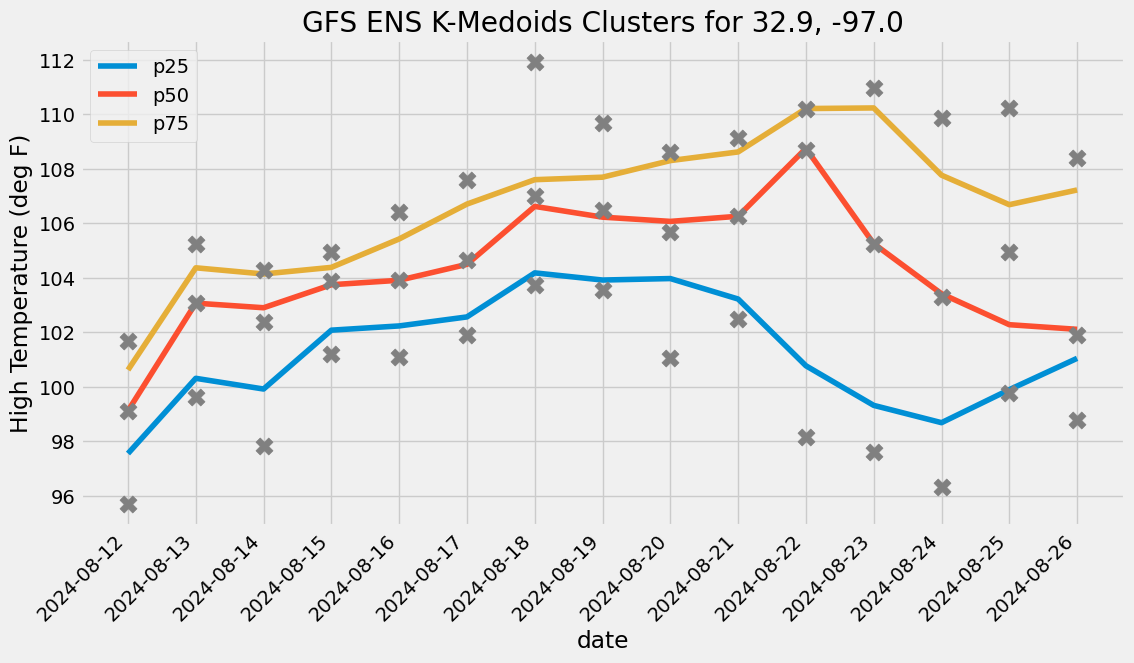

In [25]:

for n in range(0, number_clusters):
    ax = df_cluster_centers.plot.scatter(x='date', y=n, color='gray', ax=plt.gca(), 
                                         marker='X', s=150, figsize=(12, 6), zorder=10,
                                         title=f'GFS ENS K-Medoids Clusters for {LAT}, {LON}')

df_cluster_centers.plot.line(y='p25', ax=plt.gca())
df_cluster_centers.plot.line(y='p50', ax=plt.gca())
df_cluster_centers.plot.line(y='p75', ax=plt.gca())
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("High Temperature (deg F)")
plt.show()